In [1]:
import imageio.v3 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
# Path to video file (MP4 or Tiff)
file_path = "videos/well_A2.mp4"

# Decide how to ask for metadata
is_tif = Path(file_path).suffix.lower() in {".tif", ".tiff"}
meta_index = Ellipsis if is_tif else None  # Ellipsis => global TIFF metadata

# Load file with imageio
with iio.imopen(file_path, "r") as f:
    metadata = f.metadata(index=meta_index)
    image_stack = f.read()  # (F, H, W, C) for RGB; (F, H, W) for gray TIFF

# Retrieve FPS
fps = metadata.get("fps")

# Convert to grayscale when needed
image_stack_gray = image_stack.mean(axis=-1) if image_stack.ndim == 4 else image_stack

# Count frames
n_frames = image_stack_gray.shape[0] if image_stack_gray.ndim == 3 else 1

print(f"frames: {n_frames}, fps: {fps}, shape: {image_stack_gray.shape}")

frames: 450, fps: 30.0, shape: (450, 512, 512)


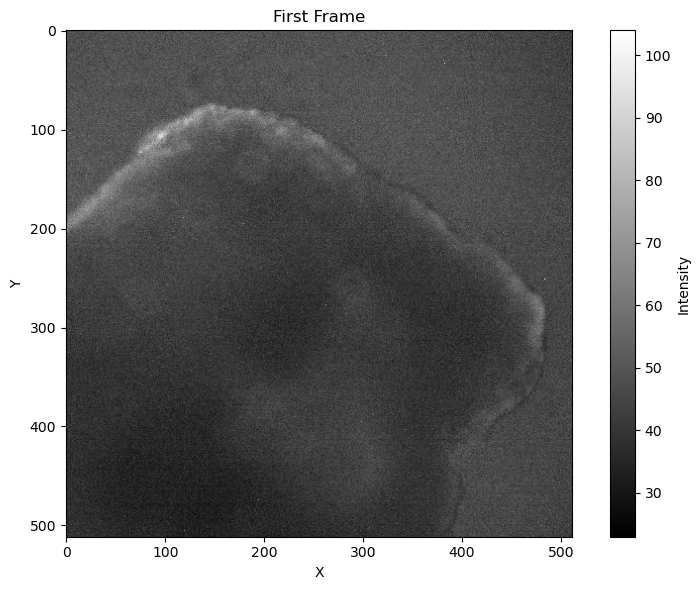

In [3]:
# Display the first frame
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(image_stack_gray[0], cmap="gray")
ax.set_title("First Frame")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.colorbar(im, ax=ax, label="Intensity")
plt.tight_layout()
plt.show()

In [4]:
# Calculate mean fluorescence per frame
mean_fluorescence_per_frame = image_stack_gray.mean(axis=(1, 2))

In [5]:
# Construct a time axis in seconds
frame_numbers = np.arange(1, len(mean_fluorescence_per_frame) + 1)
time_seconds = frame_numbers / fps

In [6]:
# Compute ΔF/F₀ (change relative to baseline)
# ΔF/F₀ normalises fluorescence changes so that 0 % means "no change" and
# 100 % would equal a doubling of brightness relative to the first frame.
baseline_f0_percentile = np.percentile(mean_fluorescence_per_frame, 10)
delta_f_over_f0 = (
    mean_fluorescence_per_frame - baseline_f0_percentile
) / baseline_f0_percentile

In [7]:
# Organize the results
results_df = pd.DataFrame(
    {
        "frame": frame_numbers,
        "time_seconds": time_seconds,
        "delta_f_over_f0_percent": delta_f_over_f0 * 100,
    }
)
results_df

,frame,time_seconds,delta_f_over_f0_percent
0,1,0.033333,38.604077
1,2,0.066667,38.776581
2,3,0.100000,37.780717
3,4,0.133333,37.652354
4,5,0.166667,36.513978
...,...,...,...
445,446,14.866667,-3.308367
446,447,14.900000,-3.744344
447,448,14.933333,-3.231487
448,449,14.966667,-4.010634


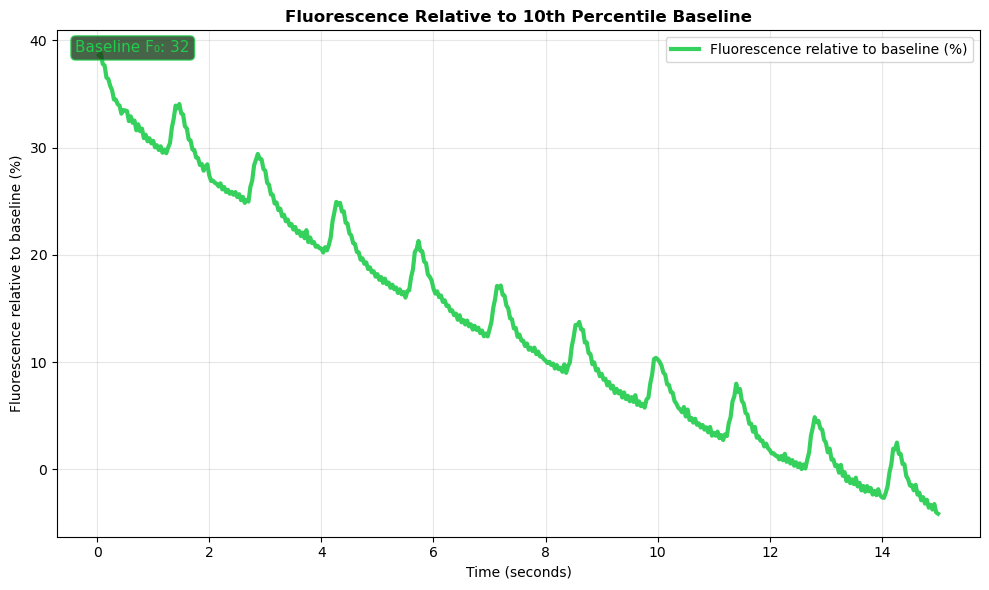

In [8]:
# Dynamics over time
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["time_seconds"],
    results_df["delta_f_over_f0_percent"],
    label="Fluorescence relative to baseline (%)",
    linewidth=3,
    color="#20CC4B",  # Custom green
    alpha=0.9,
)
plt.xlabel("Time (seconds)")
plt.ylabel("Fluorescence relative to baseline (%)")
plt.title("Fluorescence Relative to 10th Percentile Baseline", fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.text(
    0.02,
    0.98,
    f"Baseline F₀: {baseline_f0_percentile:.0f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="#1A3D1A", edgecolor="#20CC4B", alpha=0.8),
    color="#20CC4B",
)
plt.tight_layout()
plt.show()

In [9]:
# Calculate rolling 10th percentile baseline using a time window
window_size = min(
    50, len(mean_fluorescence_per_frame) // 4
)  # Use 50 frames or 1/4 of total, whichever is smaller
baseline_f0_percentile_array = np.array(
    [
        np.percentile(
            mean_fluorescence_per_frame[
                max(0, i - window_size // 2) : min(
                    len(mean_fluorescence_per_frame), i + window_size // 2 + 1
                )
            ],
            10,
        )
        for i in range(len(mean_fluorescence_per_frame))
    ]
)

# delta_f_over_f0 <= do the operation with paired indices like the . product
delta_f_over_f0_array = (
    mean_fluorescence_per_frame - baseline_f0_percentile_array
) / baseline_f0_percentile_array

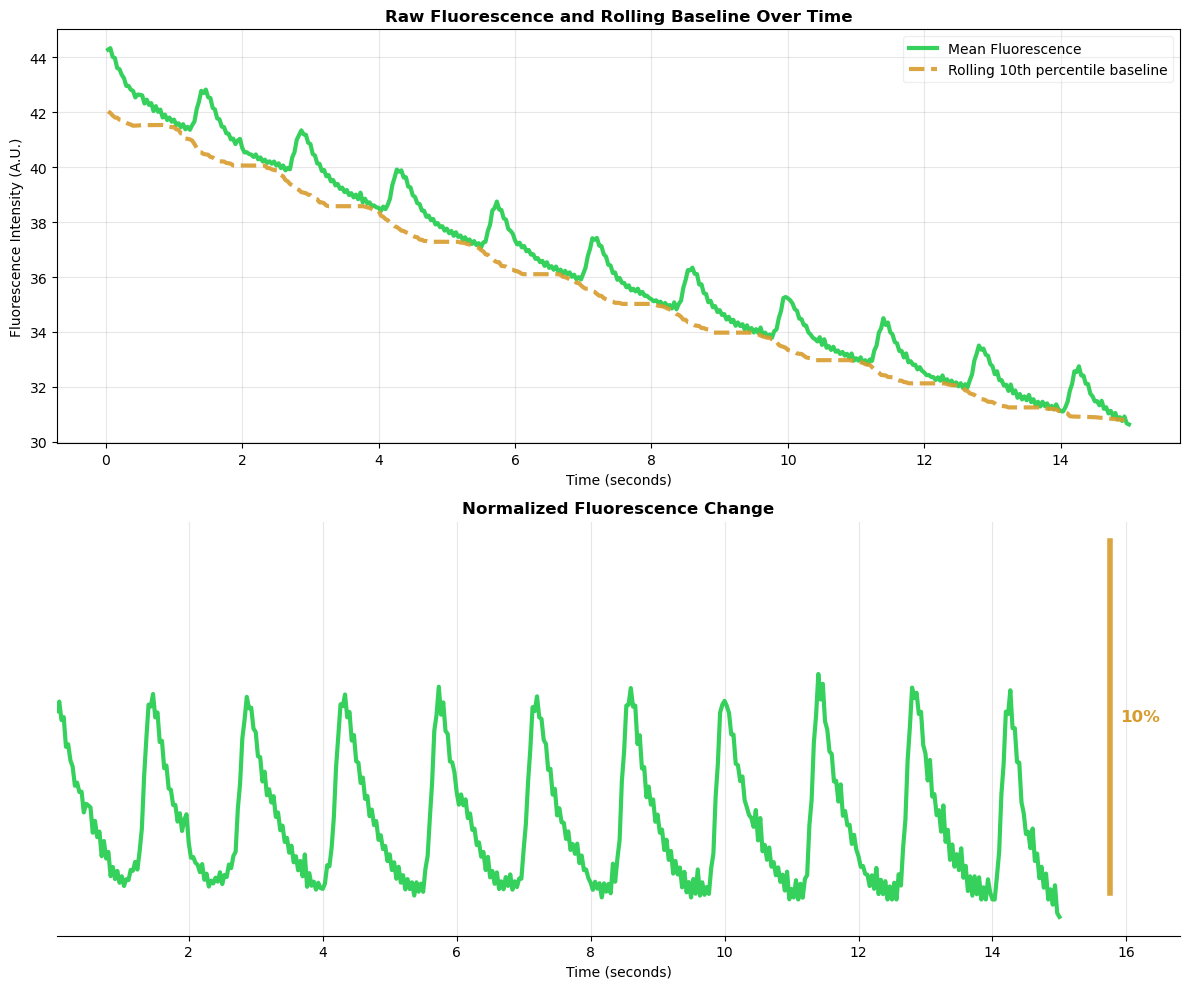

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top subplot: Mean fluorescence per frame and baseline array
ax1.plot(
    time_seconds,
    mean_fluorescence_per_frame,
    label="Mean Fluorescence",
    linewidth=3,
    color="#20CC4B",
    alpha=0.9
)
ax1.plot(
    time_seconds,
    baseline_f0_percentile_array,
    color="#D89B2D",
    linestyle="--",
    linewidth=3,
    alpha=0.9,
    label=f"Rolling 10th percentile baseline",
)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Fluorescence Intensity (A.U.)")
ax1.set_title("Raw Fluorescence and Rolling Baseline Over Time", fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', framealpha=0.3)

# Bottom subplot: ΔF/F₀ calculation with paired indices (with scale bar instead of y-axis)
ax2.plot(
    time_seconds, delta_f_over_f0_array * 100, linewidth=3, color="#20CC4B", alpha=0.9
)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("")
ax2.set_title("Normalized Fluorescence Change", fontweight='bold')
ax2.grid(True, alpha=0.3)

ax2.set_yticks([])
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

y_range = np.ptp(delta_f_over_f0_array * 100)
scale_height = max(10, y_range * 0.2)
scale_height = round(scale_height / 5) * 5
scale_x = time_seconds[-1] * 1.05
scale_y = np.min(delta_f_over_f0_array * 100) + y_range * 0.1
ax2.set_xlim(time_seconds[0], time_seconds[-1] * 1.12)

ax2.plot([scale_x, scale_x], [scale_y, scale_y + scale_height], color="#D89B2D", linewidth=4, alpha=0.9)
ax2.text(
    scale_x + time_seconds[-1] * 0.01,
    scale_y + scale_height / 2,
    f"{scale_height:.0f}%",
    va="center",
    ha="left",
    fontsize=12,
    fontweight="bold",
    color="#D89B2D",
)

plt.tight_layout()
plt.show()